### Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv(r"C:\Users\johnm\Downloads\archive (15).zip").drop(columns='customer_id')
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Target is Churn
# the target is labeled 1 if the client has left the bank during some period or 0 if he/she has not.

### Explore the Dataset

In [4]:
df.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
df.country.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

In [7]:
df.describe()
# Will need to scale based on range of values

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [9]:
pd.isnull(df).sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [10]:
df.shape

(10000, 11)

In [11]:
df.country.value_counts()
# Imbalanced, might try a confusion matrix like model,usually if target variable is imbalanced

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [12]:
df.corr() # dont need to do this

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
active_member,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


### Use of Graphs will allow us explore the data further

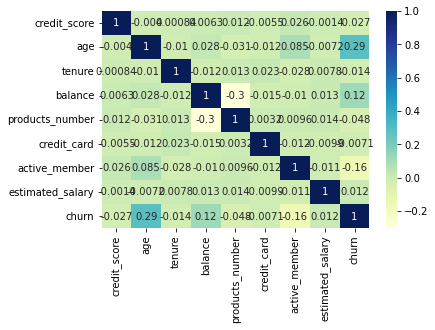

In [13]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
# seems age has the most common association with churn

Text(0.5, 1.0, 'Age vs Churn')

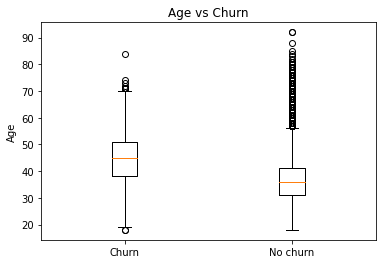

In [14]:
plt.boxplot([df[df['churn']==1]['age'], df[df['churn']!=1]['age']], labels = ["Churn", "No churn"])
plt.ylabel('Age')
plt.title('Age vs Churn')
# No churn boxplot shows many outliers which means it has alot more data then the churn boxplot.

<AxesSubplot:ylabel='Frequency'>

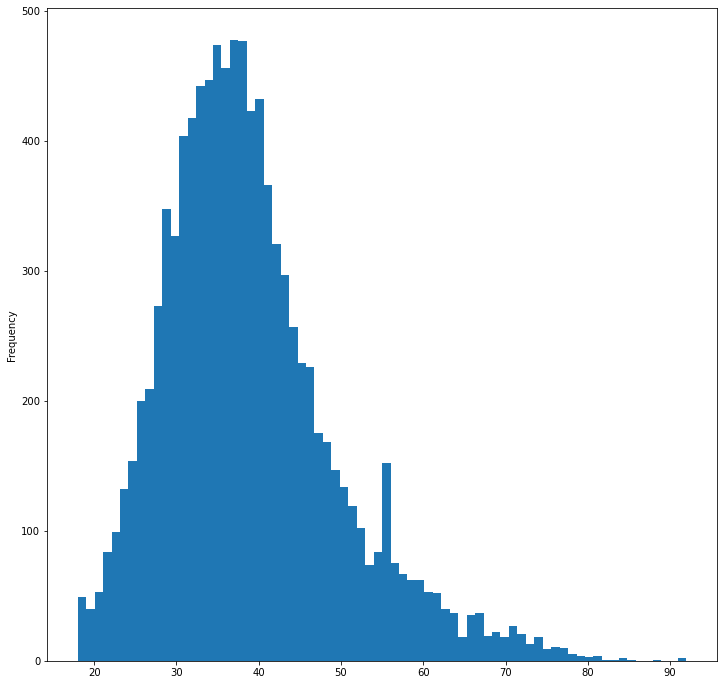

In [15]:
df.age.plot(kind = 'hist',bins = 72,figsize = (12,12))
# not many elderly values represented in the dataset in the first place
# the target is labeled 1 if the client has left the bank during some period or 0 if he/she has not.

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

gender_churn_df = df.groupby(["gender", "churn"]).count()[['age']].rename({"age": "count"}, axis=1).reset_index()
gender_churn_df = gender_churn_df.pivot(index="churn", columns="gender", values="count")
gender_churn_mat = np.array(gender_churn_df)
gender_churn_df

gender,Female,Male
churn,,
0,3404,4559
1,1139,898


In [17]:
output=pd.DataFrame(gender_churn_mat,columns=['female','male'])
output.index.name='churn'

In [18]:
output

,female,male
churn,,
0,3404,4559
1,1139,898


### One Hot Encoding

In [20]:
# convert categorical column to dummy
df_dummy = pd.get_dummies(df, drop_first=True)
kf = StratifiedKFold(n_splits=10, shuffle=True) 

In [21]:
X=df_dummy.drop('churn',axis=1)
y=df_dummy['churn']

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Check dataset to see if it is balanced

In [23]:
y.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: churn, dtype: float64

#### We see that the dataset is imbalanced as there are nearly four times as many not churned as churned.

### Logistic Regression

In [24]:
# Set the number of folds dont use
n_folds = 10 #5

# Create a KFold object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Get the k-fold cross values
folds = kf.split(X, y, groups=None)
all_accs=[]
all_precs=[]
all_recs=[]
all_f1s=[]

# Print the k-fold cross values
for i, (train_index, test_index) in enumerate(folds):
    #print(f"Fold {i+1}: train_index={train_index}, test_index={test_index}")
    
    X_train,y_train= X.iloc[train_index],y.iloc[train_index]
    X_test,y_test= X.iloc[test_index],y.iloc[test_index]
    
    lr = LogisticRegression(max_iter=800) ## ML Classification Model
    lr.fit(X_train,y_train)
    
    y_test_pred=lr.predict(X_test)
    all_accs.append(accuracy_score(y_test,y_test_pred))
    all_precs.append(precision_score(y_test,y_test_pred))
    all_recs.append(recall_score(y_test,y_test_pred))
    all_f1s.append(f1_score(y_test,y_test_pred))
    
    

Model accuracy:  0.7896
Model precision:  0.39317076955157204
Model recall:  0.05695933545832127
Model f1:  0.09916107816883935


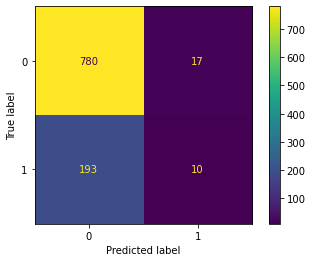

In [25]:
model_acc=np.array(all_accs).mean()
print("Model accuracy: ",model_acc)

model_prec=np.array(all_precs).mean()
print("Model precision: ",model_prec)

model_rec=np.array(all_recs).mean()
print("Model recall: ",model_rec)

model_f1=np.array(all_f1s).mean()
print("Model f1: ",model_f1)

from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred)).plot()

### Random Forest

In [26]:
#train 9000
#test 1000

In [27]:
# Set the number of folds dont use
n_folds = 10 #5

# Create a KFold object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Get the k-fold cross values
folds = kf.split(X, y, groups=None)
all_accs=[]
all_precs=[]
all_recs=[]
all_f1s=[]

# Print the k-fold cross values
for i, (train_index, test_index) in enumerate(folds):
    #print(f"Fold {i+1}: train_index={train_index}, test_index={test_index}")
    
    X_train,y_train= X.iloc[train_index],y.iloc[train_index]
    X_test,y_test= X.iloc[test_index],y.iloc[test_index]
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=8)
    rf.fit(X_train,y_train)
    
    y_test_pred=rf.predict(X_test)
    all_accs.append(accuracy_score(y_test,y_test_pred))
    all_precs.append(precision_score(y_test,y_test_pred))
    all_recs.append(recall_score(y_test,y_test_pred))
    all_f1s.append(f1_score(y_test,y_test_pred))


Model accuracy:  0.8615999999999999
Model precision:  0.8074346393794292
Model recall:  0.42171109823239644
Model f1:  0.5529547602805998


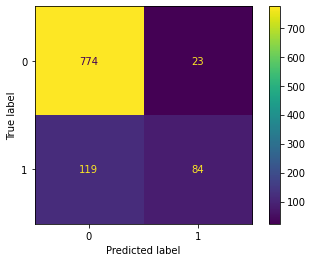

In [28]:
model_acc=np.array(all_accs).mean()
print("Model accuracy: ",model_acc)

model_prec=np.array(all_precs).mean()
print("Model precision: ",model_prec)

model_rec=np.array(all_recs).mean()
print("Model recall: ",model_rec)

model_f1=np.array(all_f1s).mean()
print("Model f1: ",model_f1)

from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred)).plot()

### XGB Classifier

In [29]:
# Set the number of folds dont use
n_folds = 10 #5

# Create a KFold object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Get the k-fold cross values
folds = kf.split(X, y, groups=None)
all_accs=[]
all_precs=[]
all_recs=[]
all_f1s=[]

# Print the k-fold cross values
for i, (train_index, test_index) in enumerate(folds):
    #print(f"Fold {i+1}: train_index={train_index}, test_index={test_index}")
    
    X_train,y_train= X.iloc[train_index],y.iloc[train_index]
    X_test,y_test= X.iloc[test_index],y.iloc[test_index]
    
    xgb = XGBClassifier(n_estimators=50, max_depth=8, eval_metric ='logloss', use_label_encoder=False)
    xgb.fit(X_train,y_train)
    
    y_test_pred=xgb.predict(X_test)
    all_accs.append(accuracy_score(y_test,y_test_pred))
    all_precs.append(precision_score(y_test,y_test_pred))
    all_recs.append(recall_score(y_test,y_test_pred))
    all_f1s.append(f1_score(y_test,y_test_pred))

Model accuracy:  0.8545999999999999
Model precision:  0.7114929544946798
Model recall:  0.4811045107698252
Model f1:  0.5732641263223747


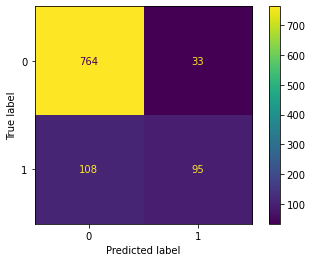

In [30]:
model_acc=np.array(all_accs).mean()
print("Model accuracy: ",model_acc)

model_prec=np.array(all_precs).mean()
print("Model precision: ",model_prec)

model_rec=np.array(all_recs).mean()
print("Model recall: ",model_rec)

model_f1=np.array(all_f1s).mean()
print("Model f1: ",model_f1)

from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred)).plot()

### Decision Tree

In [31]:
# Set the number of folds dont use
n_folds = 10 #5

# Create a KFold object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Get the k-fold cross values
folds = kf.split(X, y, groups=None)
all_accs=[]
all_precs=[]
all_recs=[]
all_f1s=[]

# Print the k-fold cross values
for i, (train_index, test_index) in enumerate(folds):
    #print(f"Fold {i+1}: train_index={train_index}, test_index={test_index}")
    
    X_train,y_train= X.iloc[train_index],y.iloc[train_index]
    X_test,y_test= X.iloc[test_index],y.iloc[test_index]
    
    dt = DecisionTreeClassifier(max_depth=8)
    dt.fit(X_train,y_train)
    
    y_test_pred=dt.predict(X_test)
    all_accs.append(accuracy_score(y_test,y_test_pred))
    all_precs.append(precision_score(y_test,y_test_pred))
    all_recs.append(recall_score(y_test,y_test_pred))
    all_f1s.append(f1_score(y_test,y_test_pred))

Model accuracy:  0.8525
Model precision:  0.7161076520986074
Model recall:  0.4565826330532213
Model f1:  0.5572624756240679


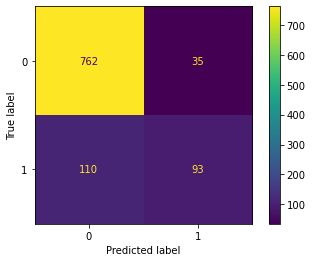

In [32]:
model_acc=np.array(all_accs).mean()
print("Model accuracy: ",model_acc)

model_prec=np.array(all_precs).mean()
print("Model precision: ",model_prec)

model_rec=np.array(all_recs).mean()
print("Model recall: ",model_rec)

model_f1=np.array(all_f1s).mean()
print("Model f1: ",model_f1)

from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred)).plot()

In [ ]:
# Random FForest had the best accuracy and precision combonation; as well as recall and f1 score.

### Grid Search Random Forest

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
params={"n_estimators":[50,100,200],"max_depth":[5,10,20],"min_samples_split":[5,10]}
rf = RandomForestClassifier()
grid_search=GridSearchCV(rf,params,cv=5)

In [35]:
# Train_Test_Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [36]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20], 'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 200]})

In [37]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

In [38]:
y_test_pred1=grid_search.best_estimator_.predict(x_test)

Model accuracy:  0.8665
Model precision:  0.76953125
Model recall:  0.48641975308641977
Model f1:  0.5960665658093797


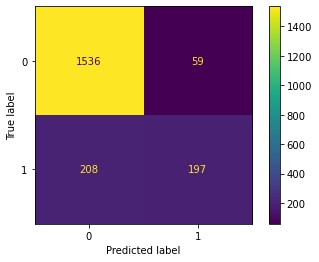

In [39]:

print("Model accuracy: ",accuracy_score(y_test,y_test_pred1))
print("Model precision: ",precision_score(y_test,y_test_pred1))
print("Model recall: ",recall_score(y_test,y_test_pred1))
print("Model f1: ",f1_score(y_test,y_test_pred1))
from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred1)).plot()

In [40]:
# this model improved accuracy but decreased precision, not good for a dataset with imbalanced data.

### Random Forrest had the best accuracy with 86.0% with a precision of nearly 81%. This is the best model since the dataset is imbalanced. This model was achieved without the GridSearch since that model resulted in a higher accuracy at the expense of a lower precision, which is not good for an imbalanced dataset. Age had the highest association with churn but it was a weak association.
